## Load up our libraries

In [1]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import datetime, geoplotlib, psycopg2, re
from geoplotlib.utils import BoundingBox
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import radians, cos, sin, asin, sqrt

In [2]:
# We will need this function to compute the distance between two (lat,lon) points, in meters
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    meters = 6367 * c * 1000
    return meters

## Loading data from PostgreSQL database I've built
### Initial exploratory analysis

We need to connect to the PostgresSQL database that I am reading the NextBus Muni data into, which is called 'sf_muni_arrivals' in our case

In [ ]:
dbname = 'sf_muni_arrivals'
username = 'dstone'

# Open up an engine, that we will use to create the database if it doesn't exist
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

if not database_exists(engine.url):
    create_database(engine.url)

The following command loads the ENTIRE SQL database from above into a pandas dataframe. In the future, I will want to sort the data first with SQL commands, then load it into a pandas dataframe. I can do that with the commented out text.

In [ ]:
# If I want to filter the data first:
# connect:
db_con = None
db_con = psycopg2.connect(database = dbname, user = username)
# the table name is 'nextbus':
sql_query = """
SELECT * FROM nextbus;
"""
df = pd.read_sql_query(sql_query,db_con)

Let's first just get some geographical data from the inbound 30-Stockton route

In [ ]:
#df.direction.str.contains('I')
route30inbound = df[(df.route == '30') & (df.direction.isnull() == False) & (df.direction.str.contains('I'))]

In [ ]:
# Let's look at the route 30 positions of this one bus over the last few minutes
route30posits = geoplotlib.utils.DataAccessObject(route30inbound[route30inbound.vehicle == 5489][['lat','lon']])
geoplotlib.tiles_provider('positron')
geoplotlib.kde(route30posits, bw=3, cut_below=1e-3, cmap='GnBu')
geoplotlib.set_bbox(BoundingBox(north=37.795,west=-122.47,south=37.685782,east=-122.35))
geoplotlib.inline(800)
geoplotlib.savefig('inbound_route_30_bus_5489')

# Show the image
Image('inbound_route_30_bus_5489')

In [ ]:
# Let's look at the route 30 positions of this one bus over the last few minutes
bus1457posits = geoplotlib.utils.DataAccessObject(df[df.vehicle == 1457][['lat','lon']])
geoplotlib.tiles_provider('positron')
geoplotlib.kde(bus1457posits, bw=3, cut_below=1e-3, cmap='GnBu')
geoplotlib.set_bbox(BoundingBox(north=37.795,west=-122.47,south=37.685782,east=-122.35))
geoplotlib.inline(800)
geoplotlib.savefig('bus_1457_posits')

# Show the image
Image('bus_1457_posits')

# This is the N-Judah line

So right now I just want to match time stamps based on the minute they were clocked. Otherwise we can't compare two buses on the same route. So the goal here is to remake the time column into only the day, hour, minute. Use pd.to_datetime on the SQL-provided timestamps, and then drop the seconds.

To make this problem tractable, and get a data plot in the next 2 hours, we will just look at the INBOUND N Judah line

In [ ]:
routeN = df[(df.route == 'N') & (df.direction.str.contains('I'))]
routeN['time_tmp'] = routeN.apply(lambda row: datetime.datetime(pd.to_datetime(row['time']).year, 
                                                                   pd.to_datetime(row['time']).month, 
                                                                   pd.to_datetime(row['time']).day, 
                                                                   pd.to_datetime(row['time']).hour, 
                                                                   pd.to_datetime(row['time']).minute), axis=1)
routeN.index = routeN.time_tmp
vehicleNumsRouteN = pd.unique(routeN.vehicle.ravel())

Fuck it, for now just do this stupid stuff manually

In [ ]:
vehicle0 = routeN[routeN.vehicle == vehicleNumsRouteN[0]][['time_tmp','lat','lon']]
vehicle0.drop_duplicates(subset='time_tmp', inplace=True)
vehicle0.columns = ['time_0','lat_0','lon_0']
#tmp0.index = tmp0.time0

# This is ridiculously memory inefficient
for i in np.arange(1,10):
    tmpvar = 'tmp' + str(i)
    tmpvar = routeN[routeN.vehicle == vehicleNumsRouteN[i]][['time_tmp','lat','lon']]
    tmpvar.drop_duplicates(subset='time_tmp', inplace=True)
    tmpvar.columns = ['time_'+str(i),'lat_'+str(i),'lon_'+str(i)]
    vehicle0[['time_'+str(i),'lat_'+str(i),'lon_'+str(i)]] = tmpvar[['time_'+str(i),'lat_'+str(i),'lon_'+str(i)]]
    vehicle0['dist0_'+str(i)] = vehicle0.apply(lambda row: haversine(row['lat_0'], row['lon_0'], row['lat_'+str(i)], row['lon_'+str(i)]), axis=1)

In [ ]:
#tmp0[tmp0.time1.isnull() == False]
vehicle0[vehicle0.dist0_3.isnull() == False].dist0_3.plot(kind='line')

In [ ]:
my_dict = {}
for i in range(1,10):
    my_key = "bin0_"+str(i)
    if my_key not in my_dict:
        my_dict[my_key] = 0

In [ ]:
for i in np.arange(1,10):
    distTemp = 'dist0_'+str(i)
    distTempPts = 'dist0_'+str(i)+'_pts'
    distTempPts = np.asarray(vehicle0[vehicle0[distTemp].isnull() == False][distTemp])
    maxTemp = 'max0_'+str(i)
    minTemp = 'min0_'+str(i)
    minTemp = min(distTempPts)
    maxTemp = max(distTempPts)
    stepTemp = 'step0_'+str(i)
    stepTemp = (maxTemp - minTemp)/(2*np.sqrt(len(distTempPts)))
    binsTemp = 'bin0_'+str(i)
    my_dict[binsTemp] = np.arange(minTemp, maxTemp, stepTemp)

In [ ]:
np.arange(1,3)

In [ ]:
f, a = plt.subplots()
f.set_size_inches(20,14)

for i in np.arange(1,4):
    distTemp = 'dist0_'+str(i)
    binsTemp = 'bin0_'+str(i)
    plot = a.hist(np.asarray(vehicle0[vehicle0[distTemp].isnull() == False][distTemp]), bins=my_dict[binsTemp], color=str(0.1+0.9*i/10), alpha=0.75)
a.set_xlabel('Distance from the N-Judah vehicle 1434')
a.set_ylabel('Effective amount of time spent at that distance')
#a.legend(('v[1]','v[2]','v[3]','v[4]','v[5]','v[6]','v[7]','v[8]','v[9]','v[10]'), loc=(0.8,0.5))
a.legend(('v[1]','v[2]','v[3]'), loc=(0.8,0.5))
f.savefig('collection_of_histograms_N_Judah_vehicles.eps')

In [ ]:
vehicle0[['dist0_1','dist0_2']].plot(kind='line')

## Loading data from NextBus-provided SQL query

Some clean up of this data: drop first row, REMOVE ALL WHITESPACES IN FILE, rename columns so they are free of whitespaces, get GPS coordinates separately

In [184]:
# Open file provided by NextBus, don't overwrite it (don't ever alter raw data!)
with open('nextbus_one_day_sf_muni_dump.csv','r') as oldname:
    data = oldname.readlines()
oldname.close()

# replace all whitespaces in file
for i, line in enumerate(data,0):
    data[i] = line.replace(' ','')

# Open new file to write un-whitespaced data to and close it
with open('nextbus_one_day_sf_muni_dump_edited.csv','w') as newfile:
    newfile.writelines(data)
newfile.close()

Now read in cleaned-up file into a dataframe, and drop the first row (which is some formatted '---' line from a SQL query), the last row (which has some NaNs as well, again from the SQL output about the number of rows)

In [3]:
nbdata = pd.read_csv('nextbus_one_day_sf_muni_dump_edited.csv',sep='|')
nbdata.drop(nbdata.index[0], inplace=True)
nbdata.drop(nbdata.index[-1], inplace=True)
nbdata.columns = ['vehicle','received_time','gps_time','gpsfix','speed','heading','route','trip']

Next we redefine the lat, lon coordinates into separate columns, and drop the old 'gpsfix' column. Finally, we reinterpret the times and coarse-grain to the minute (LATER: do to the half-minute)

In [4]:
# Clean up coordinates
def clean_nextbus_dataframe(dataframe):
    def get_coord(gps, token):
        m = re.search(r'\((.*?),(.*?)\)', gps)
        return m.group(token)

    dataframe['lat'] = dataframe.apply(lambda row: get_coord(row['gpsfix'],1), axis=1)
    dataframe['lon'] = dataframe.apply(lambda row: get_coord(row['gpsfix'],2), axis=1)
    dataframe.lat = dataframe.lat.astype(float)
    dataframe.lon = dataframe.lon.astype(float)

    dataframe.drop(['gpsfix'], inplace=True, axis=1)

    # Clean up times
    def compute_datetime(string_time):
        # We take first 18 characters because that is the length of a matching format 2016-01-1505:45:16, for example
        tmp = datetime.datetime.strptime(str(string_time)[:18],'%Y-%m-%d%H:%M:%S')
        return datetime.datetime(pd.to_datetime(tmp).year, 
                                 pd.to_datetime(tmp).month, 
                                 pd.to_datetime(tmp).day, 
                                 pd.to_datetime(tmp).hour, 
                                 pd.to_datetime(tmp).minute)

    dataframe['time'] = dataframe.apply(lambda row: compute_datetime(row['received_time']), axis=1)

    dataframe.drop(['received_time','gps_time'], inplace=True, axis=1)
    return dataframe

### First let's only look at the N-Judah inbound data
Later we can produce distributions of all routes, inbound and outbound.

The goal right now is to produce a distance distribution between each SUBSEQUENT train. So the first task is to figure out how we know two trains are subsequent.

With the data from NextBus there is no inbound/outbound identifier, so we will have to go from the trip number

In [5]:
# Only look at the N-Judah
njudah = nbdata[(nbdata.route == 'N')]

# Get unique vehicle numbers
vehiclesN = pd.unique(njudah.vehicle.ravel())

# Get unique trips, sorted in increasing order
trips_in_order = np.sort(pd.unique(njudah.trip.ravel()))

Let's just see if two subsequent trips (as identified by the precursor above) give a reasonable distance distribution

In [327]:
# Choose only the first vehicle (there are two vehicles associated to each trip, possibly inbound and outbound?)
trip_0_vehicles = pd.unique(njudah[(njudah.trip == trips_in_order[0])].vehicle.ravel())
trip_0 = njudah[(njudah.trip == trips_in_order[0]) & (njudah.vehicle == trip_0_vehicles[1])]
trip_0.drop_duplicates(subset='time', inplace=True)
trip_0.index = trip_0.time

In [328]:
trip_1_vehicles = pd.unique(njudah[(njudah.trip == trips_in_order[1])].vehicle.ravel())
trip_1 = njudah[(njudah.trip == trips_in_order[1]) & (njudah.vehicle == trip_1_vehicles[1])]
trip_1.drop_duplicates(subset='time', inplace=True)
trip_1.index = trip_1.time

In [329]:
trip_2_vehicles = pd.unique(njudah[(njudah.trip == trips_in_order[2])].vehicle.ravel())
trip_2 = njudah[(njudah.trip == trips_in_order[2]) & (njudah.vehicle == trip_2_vehicles[0])]
trip_2.drop_duplicates(subset='time', inplace=True)
trip_2.index = trip_2.time

Plan: merge the two tables with only their lat longs (time stamps included in index), compute distance on that table

In [331]:
dist1 = pd.merge(left=trip_0[['lat','lon','time']],right=trip_1[['lat','lon','time']],on='time').apply(lambda row: haversine(row['lat_x'],row['lon_x'],row['lat_y'],row['lon_y']), axis=1)
dist2 = pd.merge(left=trip_1[['lat','lon','time']],right=trip_2[['lat','lon','time']],on='time').apply(lambda row: haversine(row['lat_x'],row['lon_x'],row['lat_y'],row['lon_y']), axis=1)

In [6]:
trip_0_vehicles = pd.unique(njudah[(njudah.trip == trips_in_order[0])].vehicle.ravel())
trip_0a = njudah[(njudah.trip == trips_in_order[0]) & (njudah.vehicle == trip_0_vehicles[0])]
trip_0b = njudah[(njudah.trip == trips_in_order[0]) & (njudah.vehicle == trip_0_vehicles[1])]
# trip_0.drop_duplicates(subset='time', inplace=True)
# trip_0.index = trip_0.time

In [ ]:
# Compute distances between trip 1 and 2
dist_0_1 = 
# This is ridiculously memory inefficient
for i in np.arange(1,10):
    tmpvar = 'tmp' + str(i)
    tmpvar = routeN[routeN.vehicle == vehicleNumsRouteN[i]][['time_tmp','lat','lon']]
    tmpvar.drop_duplicates(subset='time_tmp', inplace=True)
    tmpvar.columns = ['time_'+str(i),'lat_'+str(i),'lon_'+str(i)]
    vehicle0[['time_'+str(i),'lat_'+str(i),'lon_'+str(i)]] = tmpvar[['time_'+str(i),'lat_'+str(i),'lon_'+str(i)]]
    vehicle0['dist0_'+str(i)] = vehicle0.apply(lambda row: haversine(row['lat_0'], row['lon_0'], row['lat_'+str(i)], row['lon_'+str(i)]), axis=1)

**Note: the trains in Muni usually are 2-car trains. Each car in that train has a separate vehicle ID, which makes comparing successive trains a bit more confusing! So start first with buses, which have a unique vehicle ID**

### Actually let's look at a bus route first- the 30 Stockton
Later we can produce distributions of all routes, inbound and outbound.

The goal right now is to produce a distance distribution between each SUBSEQUENT train. So the first task is to figure out how we know two trains are subsequent.

With the data from NextBus there is no inbound/outbound identifier, so we will have to go from the trip number

In [18]:
# Only look at the 30
route30 = nbdata[(nbdata.route == '30')]

# Get unique vehicle numbers
vehicles30 = pd.unique(route30.vehicle.ravel())

# Get unique trips, sorted in increasing order
trips_in_order_30 = np.sort(pd.unique(route30.trip.ravel()))

Make a dict where each dict entry is a dataframe that contains lat,lon coordinates with time-stamp (purely for computing distances)

In [28]:
coords_dict = {}
for i in range(len(trips_in_order_30)):
    my_key = "trip_"+str(i)
    if my_key not in coords_dict:
        coords_dict[my_key] = 0

for i in range(len(trips_in_order_30)):
    trip_temp = 'trip_'+str(i)
    tmp_vehicles = pd.unique(route30[(route30.trip == trips_in_order_30[i])].vehicle.ravel())
    coords_dict[trip_temp] = route30[(route30.trip == trips_in_order_30[i]) & (route30.vehicle == tmp_vehicles[0])][['lat','lon','time']]
    coords_dict[trip_temp].drop_duplicates(subset='time', inplace=True)
    coords_dict[trip_temp].index = coords_dict[trip_temp].time

Now make a dataframe that has time stamps and distances, by computing successive differences between each pair of trips, then appending (with pd.concat) each collection of (time, distance) of each pair of trips to the empty dist dataframe, which will end up containing all distances from pairs of trips on the route 30

In [70]:
dist=pd.DataFrame()

In [86]:
# substract one from length of trip_in_order_30 so that final pair of trips doesn't go outside index range
#for i in range(len(trips_in_order_30)-1):
for i in range(len(trips_in_order_30)-1):
    trip_now = 'trip_'+str(i)
    trip_next = 'trip_'+str(i+1)
    #print 'Merging {trip1} and {trip2}'.format(trip1=trip_now,trip2=trip_next)
    tmp = pd.merge(left=coords_dict[trip_now],right=coords_dict[trip_next],on='time')
    if tmp.shape[0] != 0:
        tmp['dist'] = tmp.apply(lambda row: haversine(row['lat_x'],row['lon_x'],row['lat_y'],row['lon_y']), axis=1)
        dist = pd.concat([dist, tmp[['time','dist']]])
    else:
        continue

dist.index = range(len(dist))

In [95]:
np.sort(dist['dist'])

array([  2.38129924e+00,   2.52160136e+00,   3.71688118e+00, ...,
         5.91807288e+03,   5.97846451e+03,   6.02562601e+03])

In [98]:
binnum=((max(dist['dist'])-min(dist['dist']))/np.sqrt(len(dist['dist'])))

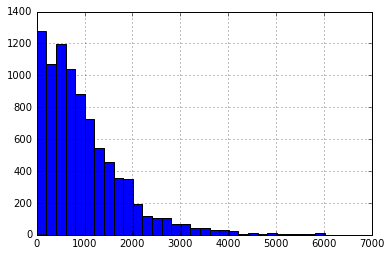

In [111]:
dist['dist'].hist(bins=30)

## Let's combine this into a single function that takes a given route and spits out the above dataframe of distances for that route

The dataframe has a list of distances between successive trips for that route.

This presumes that you are using the cleaned nbdata dataframe from above (which had all the precleaning done and takes ~10 minutes to run each time one restarts the notebook).

In [115]:
# All documentation for this function can be found in the exploration I did above for route 30 specifically
def compute_dists_for_route(route_num):
    route_dat = nbdata[(nbdata.route == route_num)]
    vehicles_for_route = pd.unique(route_dat.vehicle.ravel())
    trips_in_order_for_route = np.sort(pd.unique(route_dat.trip.ravel()))
    
    coords_dict = {}
    for i in range(len(trips_in_order_for_route)):
        my_key = "trip_"+str(i)
        if my_key not in coords_dict:
            coords_dict[my_key] = 0

    for i in range(len(trips_in_order_for_route)):
        trip_temp = 'trip_'+str(i)
        tmp_vehicles = pd.unique(route_dat[(route_dat.trip == trips_in_order_for_route[i])].vehicle.ravel())
        coords_dict[trip_temp] = route_dat[(route_dat.trip == trips_in_order_for_route[i]) & (route_dat.vehicle == tmp_vehicles[0])][['lat','lon','time']]
        coords_dict[trip_temp].drop_duplicates(subset='time', inplace=True)
        coords_dict[trip_temp].index = coords_dict[trip_temp].time
        
    dist_tmp = pd.DataFrame()
    
    for i in range(len(trips_in_order_for_route)-1):
        trip_now = 'trip_'+str(i)
        trip_next = 'trip_'+str(i+1)
        #print 'Merging {trip1} and {trip2}'.format(trip1=trip_now,trip2=trip_next)
        tmp = pd.merge(left=coords_dict[trip_now],right=coords_dict[trip_next],on='time')
        if tmp.shape[0] != 0:
            tmp['dist'] = tmp.apply(lambda row: haversine(row['lat_x'],row['lon_x'],row['lat_y'],row['lon_y']), axis=1)
            dist_tmp = pd.concat([dist_tmp, tmp[['time','dist']]])
        else:
            continue

    dist_tmp.index = range(len(dist_tmp))
    
    return dist_tmp

List of all routes available in the Muni system, so we can just choose from this list.

In [182]:
routeslist = pd.unique(nbdata['route'].ravel())
list_of_muni_routes = pd.DataFrame(data=routeslist, index = range(len(routeslist)), columns=['route'])

# Clean up a bit
list_of_muni_routes = list_of_muni_routes[(list_of_muni_routes.route.isnull() == False) & (list_of_muni_routes.route != 'Inspectors') & (list_of_muni_routes.route != 'Training')]

Route 45

In [116]:
route_45_dists = compute_dists_for_route('45')

route_45_dists.hist(bins=30)

Routes that go past my house, the 10, 19, and 48

In [121]:
route_10_dists = compute_dists_for_route('10')
route_19_dists = compute_dists_for_route('19')
route_48_dists = compute_dists_for_route('48')

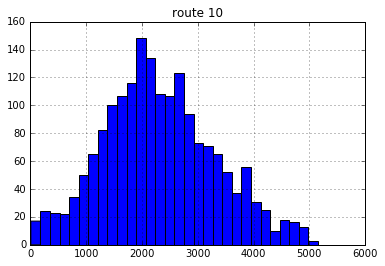

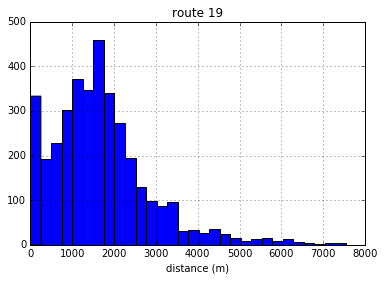

In [155]:
route_10_dists.hist(bins=30,sharey=True)
plt.title('route 10')
route_19_dists.hist(bins=30,sharey=True)
plt.title('route 19')
plt.xlabel('distance (m)')
#route_48_dists.hist(bins=30)

Create a dict of these dataframes for each route in the list_of_muni_routes

In [197]:
route_hist_dict={}
for i in list_of_muni_routes['route']:
        my_key = 'route_'+str(i)
        if my_key not in route_hist_dict:
            route_hist_dict[my_key] = 0
#build a dict here, then fill in each element of the dict 
#   with the corresponding 'compute_dists_for_route' so 
#   we have everything ready to go for each route
for route_num in list_of_muni_routes['route']:
    temp_Route = 'route_'+str(route_num)
    route_hist_dict[temp_Route] = compute_dists_for_route(route_num)

If any of these dict entries (which are each a dataframe of distances and time-stamps) are length zero, drop them from the dict

**START HERE: NEED TO ALSO DELETE THESE MISSING KEYS FROM THE list_of_muni_routes TABLE. DO THAT THEN MAKE THE PLOT OF PLOTS, THEN PERFORM THE KDE ANALYSIS DISCUSSED WITH JASON**

In [281]:
for k in route_hist_dict.keys():
    if len(route_hist_dict[k]) == 0:
        del route_hist_dict[k]

<Container object of 30 artists>

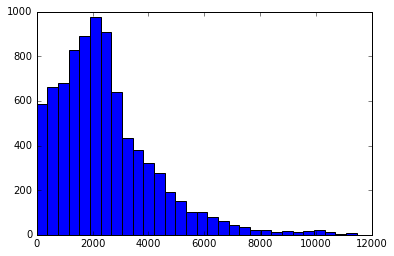

In [259]:
tmp_height, tmp_bins = np.histogram(route_hist_dict['route_29']['dist'], bins=30)
f,a = plt.subplots()
width = tmp_bins[1]-tmp_bins[0]
a.bar(tmp_bins[:-1], tmp_height, width = width)

1. subsample to make KDE computation easier
2. compute KDE for each route with subsampled distribution (with sklearn)
3. Store that
4. For edge effects with KDE, reflect dist about x=0 and then fit KDE with nice smooth tails
5. Take only positive parts of KDE

Let's try making a subfig of the first 6 histos

In [ ]:
len()

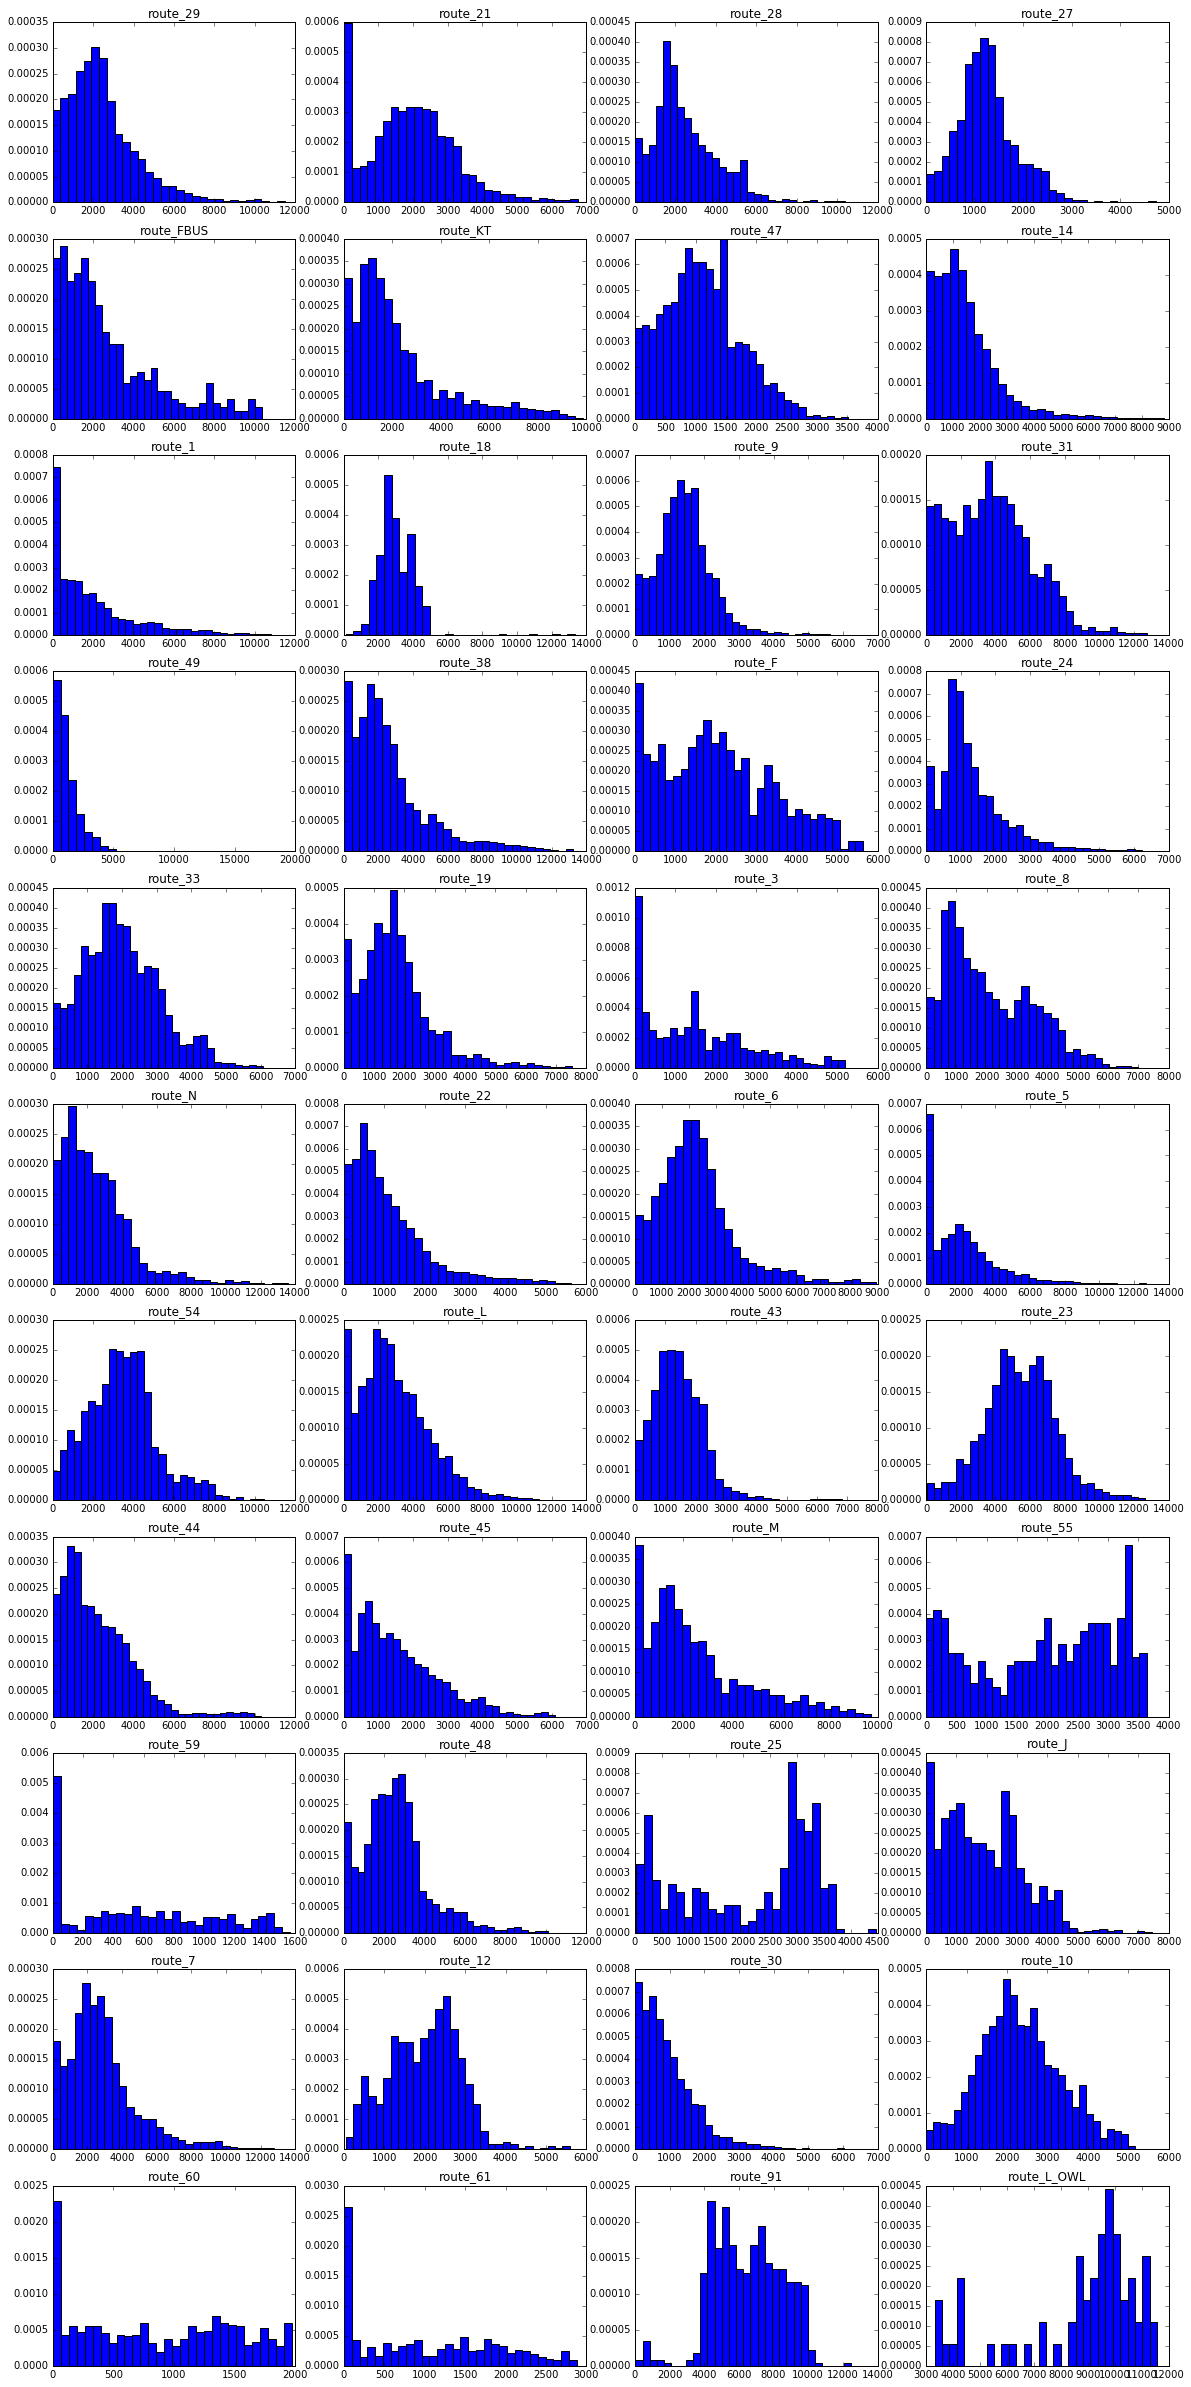

In [257]:
f, a = plt.subplots(11,4)
#f.tight_layout()
#f.set_size_inches=(15,15)
f.set_size_inches(20,42)

for i, route in enumerate(list_of_muni_routes['route'][:44],0):
    tmpRoute = 'route_'+str(route)
    tmp_height, tmp_bins = np.histogram(route_hist_dict[tmpRoute]['dist'], bins=30, normed=1)
    width = tmp_bins[1]-tmp_bins[0]
    #tmpPlt = route_hist_dict[tmpRoute].hist(bins=30)
    a[i/4,i%4].bar(tmp_bins[:-1], tmp_height, width = width)
    #a[i/2,i%2].set_xticks(None)
    a[i/4,i%4].set_title(tmpRoute)

In [ ]:
f.savefig('all_muni_routes_distance_dists.png')

In [248]:
for i, route in enumerate(list_of_muni_routes['route'][45:49],0):
    print i, route

0 K_OWL
1 2
2 5R
3 8BX


In [254]:
route_hist_dict['route_8BX']

,time,dist
0,2016-01-14 15:30:00,12.603052
1,2016-01-14 15:31:00,12.603052
2,2016-01-14 15:33:00,12.603052
3,2016-01-14 15:34:00,12.188149
4,2016-01-14 15:36:00,226.789876
5,2016-01-14 15:37:00,473.488889
6,2016-01-14 15:39:00,521.093437
7,2016-01-14 15:40:00,299.752682
8,2016-01-14 15:41:00,324.712537
9,2016-01-14 15:42:00,345.807247


## Scratch

In [ ]:
for i in list_of_muni_routes['route']:
        my_key = 'route_'+str(i)
        if my_key not in route_hist_dict:
            route_hist_dict[my_key] = 0

In [276]:
temp_dict={}
for i in range(10):
    key = 'i'+str(i)
    if key not in temp_dict:
        temp_dict[key] = np.random.rand()

In [277]:
temp_dict

{'i0': 0.9631695162704917,
 'i1': 0.14817954773175768,
 'i2': 0.4717067832801283,
 'i3': 0.49693723365084197,
 'i4': 0.7779825514437158,
 'i5': 0.6493972713144742,
 'i6': 0.683647897682547,
 'i7': 0.7344394717791287,
 'i8': 0.003032196210960847,
 'i9': 0.6964750231137039}

In [280]:
temp_dict

{'i0': 0.9631695162704917,
 'i2': 0.4717067832801283,
 'i3': 0.49693723365084197,
 'i4': 0.7779825514437158,
 'i5': 0.6493972713144742,
 'i6': 0.683647897682547,
 'i7': 0.7344394717791287,
 'i9': 0.6964750231137039}